# 1.Frame the problem

The objective of this challenge is to work with 'dirty data'. Most real data is dirty and the availability of high-quality, open-source ML and data analysis frameworks (such as [scikit-learn](https://scikit-learn.org/),
[pandas](https://pandas.pydata.org/)...) means that the next frontier for tooling and automation lies in preprocessing. This challenge aims to investigate methodologies to perform statistical analysis directly on the original dirty data.

There are two datasets in this challenge:

* `company_revenue_TRAIN.csv` - company revenue declarations.
* `award_notices_RAMP.csv` -  French Attribution Notices.

### Aim

The predictive aim of this challenge is to use `company_revenue_TRAIN.csv` and `award_notices_RAMP.csv` to predict the Revenue for each entry in the 'company financial data' dataset. It is advised that you use both datasets, as it improves the prediction (see [Score comparison](#Score-comparison)), but using only the `company_revenue_TRAIN.csv` dataset is also allowed.

### Data

### Company financial data

This dataset was built from an extract of the [National Institute of Statistics and Economic Studies (INSEE)](https://www.insee.fr/en/accueil) reference database of company revenue declarations from 2013 to 2018. Each row represents the declaration of one company for one year and the following information is provided in the columns:

* `Legal_ID` - the reconcilled legal ID of the company
* `Name` - the name of the company
* `Activity_code (APE)` - 'Activite Principale de l'Entreprise', the main activity of the company - more information in [English](https://www.startbusinessinfrance.com/code-ape) or in [French](https://www.service-public.fr/professionnels-entreprises/vosdroits/F33050)
* `Address` 
* `Zipcode`
* `City`
* `Revenue` - in Euros
* `Headcount`
* `Fiscal_year_end_date`
* `Fiscal_year_duration_in_months`
* `Year`

There are a few things to note:

* there are revenue declarations for the same company but different years
* there is a large reduction in entries for the years 2017 and 2018 due to the Loi Macron law in 2017
* the 'same company' can have several different entities, resulting in entries where the `Legal_ID` is different but the `Name`, `Address`, `City` and `Zipcode` are all the same.
* `Revenue` can be negative. A negative revenue may be due to cancelled orders from the previous fiscal year that was recorded in the current fiscal year.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# 2. Get the data

In [2]:
revenue_train = pd.read_csv('data/company_revenue_public_TRAIN.csv')
revenue_test = pd.read_csv('data/company_revenue_public_TEST.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 3. Data exploration

## 3.1. General

In [3]:
revenue_train.shape

(1495948, 11)

In [4]:
revenue_train.columns

Index(['Legal_ID', 'Name', 'Activity_code (APE)', 'Address', 'Zipcode', 'City',
       'Revenue', 'Headcount', 'Fiscal_year_end_date',
       'Fiscal_year_duration_in_months', 'Year'],
      dtype='object')

In [5]:
# rename columns
colnames = list(revenue_train.columns)
colnames = [x.lower() for x in colnames]
colnames = [x.replace(' ', '_') for x in colnames]
colnames[2] = 'ape'

In [6]:
revenue_train.columns = colnames

In [7]:
revenue_train.dtypes

legal_id                            int64
name                               object
ape                                object
address                            object
zipcode                           float64
city                               object
revenue                           float64
headcount                         float64
fiscal_year_end_date               object
fiscal_year_duration_in_months    float64
year                              float64
dtype: object

In [8]:
revenue_train.head()

,legal_id,name,ape,address,zipcode,city,revenue,headcount,fiscal_year_end_date,fiscal_year_duration_in_months,year
0,582296,COMICOB,NaN,BOULOUPARIS BP 15 BOULOUPARIS,NaN,NaN,104334380.0,NaN,2016-12-31,12.0,2016.0
1,582981,CIANFARANI JEAN-MICHEL,NaN,33 AVENUE H. LAFLEUR - VICTOIRE - B.P. 4031 NO...,NaN,NaN,28535069.0,NaN,2016-12-31,12.0,2016.0
2,588541,OK POULET 5EME SARL,NaN,23 RUE PAUL BERT,98800.0,NOUMEA,10481715.0,1.0,2016-12-31,12.0,2016.0
3,589275,INSTITUT DE LA QUALITE S.A.R.L.,NaN,224 RUE J. IEKAWE - COMPLEXE DE LA BELLE-VIE -...,98800.0,NOUMEA,66097924.0,NaN,2016-12-31,12.0,2016.0
4,592972,EXPERT TRADE,NaN,2 RUE DE L ASTROLABE OUEMO MAGENTA,98800.0,NOUMEA,15271453.0,NaN,2016-12-31,12.0,2016.0


In [9]:
revenue_train.isna().sum()

legal_id                               0
name                                   3
ape                                18390
address                           262234
zipcode                           251235
city                                 468
revenue                                0
headcount                         953576
fiscal_year_end_date                   0
fiscal_year_duration_in_months         0
year                                   0
dtype: int64

In [10]:
revenue_train.describe()

,legal_id,zipcode,revenue,headcount,fiscal_year_duration_in_months,year
count,1.495948e+06,1.244713e+06,1.495948e+06,5.423720e+05,1495948.0,1.495948e+06
mean,5.060829e+08,5.464419e+04,4.488752e+06,8.736985e+01,12.0,2.014475e+03
std,1.417373e+08,2.755171e+04,2.714711e+08,9.002249e+03,0.0,1.246598e+00
min,5.822960e+05,6.000000e+00,-2.207296e+07,-3.900000e+01,12.0,2.013000e+03
25%,4.149439e+08,3.185000e+04,9.456375e+04,1.000000e+00,12.0,2.013000e+03
50%,4.895445e+08,6.053000e+04,2.877205e+05,3.000000e+00,12.0,2.014000e+03
75%,5.293306e+08,7.511600e+04,1.005522e+06,9.000000e+00,12.0,2.015000e+03
max,9.999905e+08,9.889500e+04,2.427252e+11,5.450000e+06,12.0,2.018000e+03


## 3.2. Outcome variable

In [11]:
# no missing values
revenue_train['revenue'].isna().sum()

0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017B8CBB39C8>]],
      dtype=object)

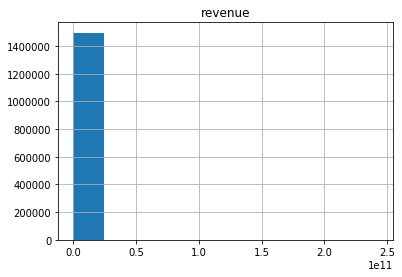

In [12]:
revenue_train.hist(column='revenue')

In [13]:
# number of zeros in revenues
print("number of zeros:", revenue_train[revenue_train['revenue'] == 0].shape[0])
print("number of values<1:", revenue_train[revenue_train['revenue'] <= 1].shape[0])

number of zeros: 50047
number of values<1: 51050


In [14]:
# proportion of zeros in revenues
revenue_train[revenue_train['revenue'] <= 0].shape[0] / revenue_train.shape[0]

0.03407337688208414

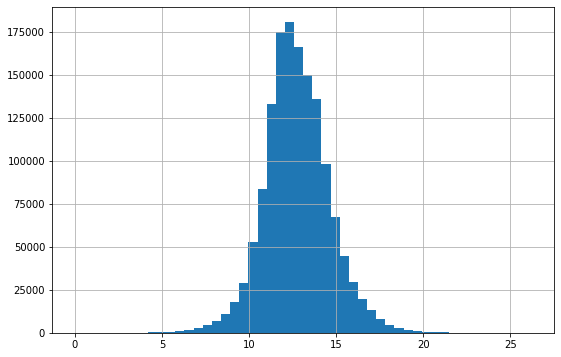

In [15]:
np.log(revenue_train['revenue'][revenue_train['revenue'] > 0]).hist(bins=50, figsize=(9,6))

# 4. Prepare the data

Plusieurs étapes: 

1. Mettre en forme `zipcode`, `fiscal_year_end_date`, `ape`, `headcount`:
    - `zipcode`: ne garder que le département
    - `fiscal_year_end_date`: mettre en format datetime et séparer year, month, day
    - `ape`: ne garder que les deux premier chiffres (domaine d'activité agrégé
    - `headcount`: mettre en log (log1p)


2. Imputer par la valeur la plus fréquente pour les quatre variables ci-dessus.


3. One-hot encoding pour `zipcode`, `fiscal_year_end_date`, `ape`


4. Droper les colonnes suivantes pour l'instant: `Legal_ID`, `Name`, `Address`, `City`, `Fiscal_year_duration_in_months`

In [16]:
revenue_train = revenue_train[:1000]

In [17]:
# only keep year for now
def clean_date(X):
    date = pd.to_datetime(X['fiscal_year_end_date'], format='%Y-%m-%d')
    return np.c_[date.dt.year]

date_transformer = FunctionTransformer(clean_date, validate=False)

In [18]:
# only keep the first two digits in the ape codes
def clean_zipcode(X):
    depart = X['zipcode'].astype(str).str[:2]
    return pd.to_numeric(depart, errors='coerce').values[:, np.newaxis]

zipcode_transformer = FunctionTransformer(clean_zipcode, validate=False)

In [19]:
# only keep the first two characters in the ape codes
def clean_ape(X):
    ape = X['ape'].str[:2]
    return pd.to_numeric(ape, errors='coerce').values[:, np.newaxis]

ape_transformer = FunctionTransformer(clean_ape, validate=False)

In [20]:
# log1p for headcount
def clean_headcount(X):
    headcount = np.log1p(X['headcount'])
    return headcount.values[:, np.newaxis]

headcount_transformer = FunctionTransformer(clean_headcount, validate=False)

In [ ]:
# one-hot encoding for 

In [23]:
prepocessing_pipeline = ColumnTransformer([
    ('zipcode', make_pipeline(zipcode_transformer, SimpleImputer(strategy="most_frequent")), ['zipcode']),
    ('date', make_pipeline(date_transformer, SimpleImputer(strategy="most_frequent")), ['fiscal_year_end_date']),
    ('ape', make_pipeline(ape_transformer, SimpleImputer(strategy="most_frequent")), ['ape']),
    ('headcount', make_pipeline(headcount_transformer, SimpleImputer(strategy="median")), ['headcount'])
], remainder='drop')

In [24]:
prepocessing_pipeline.fit_transform(revenue_train)

array([[2.10000000e+01, 2.01600000e+03, 6.80000000e+01, 2.94443898e+00],
       [2.10000000e+01, 2.01600000e+03, 6.80000000e+01, 2.94443898e+00],
       [9.80000000e+01, 2.01600000e+03, 6.80000000e+01, 6.93147181e-01],
       ...,
       [6.10000000e+01, 2.01300000e+03, 9.30000000e+01, 2.94443898e+00],
       [6.10000000e+01, 2.01400000e+03, 9.30000000e+01, 2.94443898e+00],
       [6.10000000e+01, 2.01500000e+03, 9.30000000e+01, 2.94443898e+00]])

## 4.4. Train set

In [126]:
X_prepared = full_pipeline.fit_transform(revenue_train)
y_true = np.array(revenue_train['revenue'])[:, np.newaxis]

# 5. Explore models

### Linear regression

In [ ]:
# fit the model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

In [ ]:
# predictions on train set
lin_reg_pred_train = lin_reg.predict(X_train)
lin_reg_mse = mean_squared_error(y_true=y_train, y_pred=lin_reg_pred_train)
lin_reg_rmse = np.sqrt(lin_reg_mse)

In [ ]:
lin_reg_rmse

In [ ]:
# cross validation
lin_reg_scores = cross_val_score(lin_reg, X=X_train, y=y_train, cv=10,
                         scoring="neg_mean_squared_error")
lin_reg_rmse_scores = np.sqrt(-lin_reg_scores)

In [ ]:
lin_reg_rmse_scores.mean()

In [ ]:
steps = [('lin_reg', LinearRegression())]
pipeline = Pipeline(steps)

In [ ]:
pipeline.fit(X=X_train, y=y_train)

In [ ]:
y_pred_train = pipeline.predict(X_train)

In [ ]:
# R2 de la prediction
pipeline.score(X_train, y_train)

### Define the score

In [ ]:
def loss(y_true, y_pred):
    
    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    true = np.maximum(5., np.log10(np.maximum(1., y_true)))
    pred = np.maximum(5., np.log10(np.maximum(1., y_pred)))
    
    loss = np.mean(np.abs(true - pred))
    
    return loss
    
fan_loss = make_scorer(loss, greater_is_better=False)

In [ ]:
loss(y_true=y_train, y_pred=y_pred_train)

# 6. Fine-tune the models

# 7. Results